In [16]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

train = pd.DataFrame.from_records(json.load(open('train.json'))).fillna("")
test = pd.DataFrame.from_records(json.load(open('test.json'))).fillna("")



train['author_combined'] = train['author'].apply(lambda x:'?'.join(map(str, x)) if x is not None else '')
test['author_combined'] = test['author'].apply(lambda x:'?'.join(map(str, x)) if x is not None else '')
train['text_combined'] = train['title'] + train['abstract']
test['text_combined'] = test['title'] + test['abstract']


train, val = train_test_split(train, stratify=train['year'], random_state=123)

featurizer = ColumnTransformer([
    ("tfidf_title", TfidfVectorizer(min_df=0.00001, stop_words='english'), "title")
],
    remainder='drop'
)

# featurizer = ColumnTransformer([
#     ("tfidf_authors", TfidfVectorizer(tokenizer=lambda text: text.split('?'), token_pattern=None), "author_combined"),
#     ("tfidf_abstract", TfidfVectorizer(min_df=0.01, stop_words='english'), "abstract"),
#     ("tfidf_title", TfidfVectorizer(min_df=0.01, stop_words='english'), "title"),
#     ("tfidf_publisher", TfidfVectorizer(), "publisher"),
#     ("tfidf_text", TfidfVectorizer(min_df=0.01, stop_words="english"), "text_combined"),
#     ("ohe", OneHotEncoder(handle_unknown='ignore'), ["ENTRYTYPE", "publisher"])],
#     remainder='drop'
# )


# pipe = Pipeline([('featurizer', featurizer), ('ridge', Ridge(alpha=1))])
pipe = Pipeline([('featurizer', featurizer),
                 ('logistic_reg', LogisticRegression(verbose=2,
                                                    n_jobs=-1,
                                                    max_iter=100))])
# pipe = Pipeline([('featurizer', featurizer), ('rfr', RandomForestRegressor(n_jobs=-1, verbose=10))])
# pipe = Pipeline([('featurizer', featurizer), ('sgd', SGDClassifier(verbose=10) )])

pipe.fit(train.drop('year', axis=1), train['year'].values)

err_train = mean_absolute_error(train['year'].values, pipe.predict(train.drop('year', axis=1)))
err_val = mean_absolute_error(val['year'].values, pipe.predict(val.drop('year', axis=1)))
print()
print(f"Train MAE:       {err_train:.3f}")
print(f"Validation MAE:  {err_val:.3f}")
print()



# grid_search = GridSearchCV(pipe, param_grid = param_grid, cv=3, verbose=10, n_jobs=-1)
# grid_search.fit(train.drop('year', axis=1), train['year'].values
# print(grid_search.cv_results_)

pred = pipe.predict(test)
test['year'] = pred
test.to_json("predicted.json", orient='records', indent=2)




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.0s finished



Train MAE:       5.277
Validation MAE:  6.168



In [17]:
word_coef = abs(pipe['logistic_reg'].coef_[0])
word_names = pipe.named_steps["featurizer"].named_transformers_['tfidf_title'].get_feature_names_out()

X_dtm = pipe.named_steps["featurizer"].named_transformers_['tfidf_title'].transform(train['title'])
word_freq = X_dtm.sum(axis=0).A.ravel().astype(int)

word_importances = pd.DataFrame({'word': word_names, 'coef': word_coef, 'freq': word_freq})

print(f"amount of words:  {len(word_names)}")
word_importances.sort_values('coef', ascending=False)[0:50]

amount of words:  25007


,word,coef,freq
13286,mechanical,2.932265,17
22308,translation,2.131322,1000
13559,microsemantics,0.862838,1
17083,problems,0.841355,46
13293,mechanized,0.732825,1
12855,machine,0.721087,785
24159,word,0.679207,582
22244,transcript,0.677337,3
4358,conference,0.667397,111
20641,storage,0.580040,4


<BarContainer object of 432 artists>

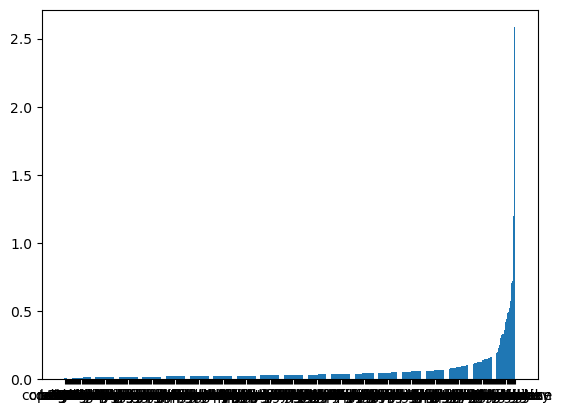

In [13]:
import matplotlib.pyplot as plt
plt.bar(word_importances.sort_values('coef')['word'], word_importances.sort_values('coef')['coef'])

### Permutation Feature Importance

<BarContainer object of 8 artists>

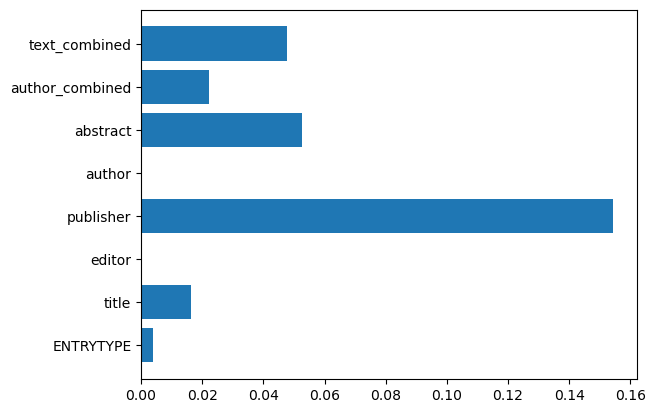

In [69]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

feat_imp = permutation_importance(pipe,
                                  X = val.drop('year', axis=1),
                                  y = val['year'].values)


# for feature, importance in zip(pipe['featurizer'].feature_names_in_, feat_imp.importances_mean):
#     print(f"{feature: <15}: {importance:.2} ")

plt.barh(pipe['featurizer'], feat_imp.importances_mean).feature_names_in_

In [103]:
import numpy as np
train['residuals'] = np.absolute(pipe.predict(train.drop('year', axis=1)) - train['year'].values.astype(np.int32))
train.sort_values('residuals', ascending=True)[0:5]


TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [101]:
plt.scatter(train['year'], train['residuals'], s=1)
plt.title("Residuals of predicted outcomes on training set, by year")
plt.show()

KeyError: 'residuals'

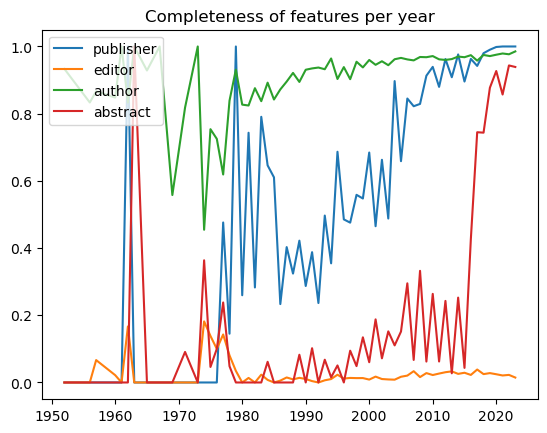

In [100]:
train['year'] = train['year'].astype(int)

completeness = {}
for feature in ['publisher', 'editor', 'author', 'abstract']:
    completeness[feature] = 1 - (train.groupby('year')[feature].apply(lambda x: x.eq('').sum()) / train.groupby('year').size())
    plt.plot(completeness[feature].index, completeness[feature].values, label=feature)

plt.title("Completeness of features per year")
plt.legend(loc='upper left')
plt.show()